# Camera Image Capture

## Setup python dependencies

```bash
# to install picamera2
$ sudo apt update
$ sudo apt upgrade
$ sudo apt install -y python3-picamera2

# create venv using system packages
$ python -m venv --system-site-packages .venv

# activate venv and install additional dependencies
$ source .venv/bin/activate
$ pip install torch torchvision torchaudio opencv-python matplotlib jupyter
```

In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

import cv2
import IPython.display as ipython
import ipywidgets as widgets

from pieye.camera import Camera


In [2]:
cam = Camera()

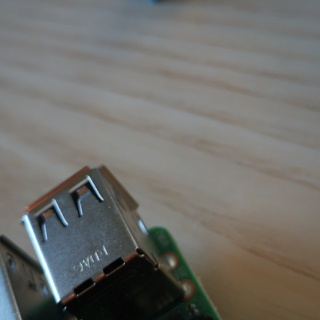

None

Button(button_style='danger', description=' Start Camera', icon='play', style=ButtonStyle())

Button(description=' Capture', disabled=True, style=ButtonStyle())

Button(description='Save', disabled=True, style=ButtonStyle())

Output()

In [4]:
from collections import deque
from time import time
import threading


display_handle = ipython.display(None, display_id=True)
captured_frame_display_handle = ipython.display(None, display_id=True)

start_btn = widgets.Button(description=" Start Camera", button_style="danger", icon="play")
capture_btn = widgets.Button(description=" Capture", disabled=True)
save_btn = widgets.Button(description="Save", disabled=True)
out = widgets.Output()

is_started = False
queue = deque()
frame = None
captured_frame = None


def print_log(msg):
    with out:
        print(msg)


def start_cam():
    global is_started
    global frame

    try:
        cam.start()
        while is_started:
            frame = cam.get_frame()
            if frame is not None:
                _, img = cv2.imencode('.jpeg', frame)
                display_handle.update(ipython.Image(data=img.tobytes()))
    except Exception as e:
        print_log(e.msg)

    cam.stop()


def on_capture(b):
    # get frame into captured_frame and display
    global captured_frame
    
    captured_frame = frame
    if captured_frame is not None:
        save_btn.disabled = False
        _, img = cv2.imencode('.jpeg', captured_frame)
        captured_frame_display_handle.update(ipython.Image(data=img.tobytes()))


def on_save(b):
    # save captured_frame into a file w/ the timestamp as the name
    global captured_frame
    
    if captured_frame is not None:
        cv2.imwrite(f"{int(time())}.jpg", captured_frame)
        b.disabled = True
        captured_frame = None
        captured_frame_display_handle.update(None)


def on_start(b):
    global is_started
    
    if is_started:
        is_started = False
        capture_btn.disabled = True
        b.description = " Start Camera"
        b.icon = "play"

        try:
            print_log("stopping camera thread")
    
            if len(queue) > 0:
                thread = queue.popleft()
                thread.join()
        except Exception as e:
            print_log(e)
    else:
        is_started = True
        capture_btn.disabled = False
        b.description = " Stop Camera"
        b.icon = "stop"

        try:
            print_log("starting camera thread")
            thread = threading.Thread(target=start_cam)
            thread.start()
            queue.append(thread)
        except Exception as e:
            print_log(e)
            

start_btn.on_click(on_start)
capture_btn.on_click(on_capture)
save_btn.on_click(on_save)
display(start_btn, capture_btn, save_btn, out)